Dataset Description:
Introduction:
Recommender systems are among the most popular applications of data science today. They are used to predict “best next action” for a customer or “rating of preference” that a user would give to items. Today, major tech company has applied them in some form or the other. For example, YouTube uses it to decide which video to play next on autoplay, Facebook uses it to recommend pages to like and people to follow, and Amazon uses it to suggest products to customers, and so on. In general, there are three ways to build a recommendation engine:
1. Popularity based recommendation engine
2. Content based recommendation engine
3. Collaborative filtering based recommendation engine
Another type of recommendation system is Hybrid model which can be created by mixing two or more types of recommendation systems. This type of recommendation systems usually gives better performance.

The IPTV dataset contains the following features and it has more than 70 million rows and the size of data is more than 1 terabyte (TB), a sample is provided here:
- User ID
- SESSION START (DATE/TIME)
- SESSION DURATION
- PROGRAM NAME
- PROGRAM DESCRIPTION
- PREOGRAM GENRE
- PROGRAM CLASS
- SERIES TITLE
- SERIES NAME
- Episode title
- Episode number

# Recommendations with STC Data

In this notebook, I will be putting recommendation techniques to use on real data from the STC OpenData Source.

By following the table of contents, you will find a number of different methods for making recommendations that can be used for different situations. 

## Table of Contents

1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
2. [Rank Based Recommendations](#Rank)<br>
3. [User-User Based Collaborative Filtering](#User-User)<br>
4. [Matrix Factorization](#Matrix-Fact)<br>
5. [Extras & Concluding](#conclusions)
6. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>


# Loading Data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as image
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

%matplotlib inline
stc = pd.read_csv('Final_Dataset.txt', delimiter = ",")

In [8]:
stc = stc.drop('Unnamed: 0', axis=1)

In [9]:
# creating unique id for videos
df = stc.copy()
df['vid_id'] = df.groupby(['original_name']).ngroup()
df.head()

,date_,user_id_maped,program_name,duration_seconds,program_class,season,episode,program_desc,program_genre,series_title,hd,original_name,vid_id
0,2017-05-27,26138,100 treets,40,MOVIE,0,0,Drama Movie100 Streets,Drama,0,0,100 treets,2
1,2017-05-21,7946,Moana,17,MOVIE,0,0,Animation MovieMoana (HD),Animation,0,1,Moana,924
2,2017-08-10,7418,The Mermaid Princess,8,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess,1524
3,2017-07-26,19307,The Mermaid Princess,76,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess,1524
4,2017-07-07,15860,Churchill,87,MOVIE,0,0,Biography MovieChurchill (HD),Biography,0,1,Churchill,317


# Data Processing

In [10]:
# chooseing columns we need for recommandation
df = df[['user_id_maped', 'vid_id','program_name', 'program_class', 'season', 'episode', 'program_genre', 'hd',  'date_', 'original_name']]

# rename cols
df.columns = ['user_id', 'vid_id','program_name', 'program_class', 'season', 'episode', 'program_genre', 'hd',  'date', 'original_name']

# create date year and months
df['year']  =  [int(x[:4]) for x in df['date']]
df['month'] = [int(x[5:7]) for x in df['date']]
df['date']  = pd.to_datetime(df.date,format='%Y/%m/%d')

In [11]:
df.program_class = df.program_class.replace('MOVIE', "Movie")
df.program_class = df.program_class.replace('SERIES/EPISODES', "TV Show")
df.program_genre = df.program_genre.replace('SERIES_NOT_ADDED_UNDER_ANY_GENRE', "Others")
df.program_genre = df.program_genre.replace('NOT_DEFINED_IN_UMS', "Others")

In [12]:
df.head()

,user_id,vid_id,program_name,program_class,season,episode,program_genre,hd,date,original_name,year,month
0,26138,2,100 treets,Movie,0,0,Drama,0,2017-05-27,100 treets,2017,5
1,7946,924,Moana,Movie,0,0,Animation,1,2017-05-21,Moana,2017,5
2,7418,1524,The Mermaid Princess,Movie,0,0,Animation,1,2017-08-10,The Mermaid Princess,2017,8
3,19307,1524,The Mermaid Princess,Movie,0,0,Animation,1,2017-07-26,The Mermaid Princess,2017,7
4,15860,317,Churchill,Movie,0,0,Biography,1,2017-07-07,Churchill,2017,7


# <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598607 entries, 0 to 3598606
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   vid_id         int64         
 2   program_name   object        
 3   program_class  object        
 4   season         int64         
 5   episode        int64         
 6   program_genre  object        
 7   hd             int64         
 8   date           datetime64[ns]
 9   original_name  object        
 10  year           int64         
 11  month          int64         
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 329.5+ MB


In [14]:
# check for nulls
df.isna().sum()

user_id          0
vid_id           0
program_name     0
program_class    0
season           0
episode          0
program_genre    0
hd               0
date             0
original_name    0
year             0
month            0
dtype: int64

In [15]:
# check for duplicated
print('Number of Duplicate Records {}'.format(df.duplicated().sum()))
print('Percentage of Duplicates on Full Data %{}'.format(round(df.duplicated().sum()/df.shape[0]*100,2)))

Number of Duplicate Records 1027754
Percentage of Duplicates on Full Data %28.56


### Outliers

<IPython.core.display.Javascript object>

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


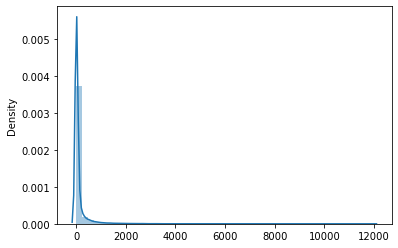

In [16]:
user_act = df.groupby(by='user_id')['vid_id'].count()

before_outlier = user_act.values
ax = sns.distplot(before_outlier)

#### Lets discuess this outlier of max number of users which can tell us something important. We understand that Jawwy service is similar to Netflix and know that users watch a lot of content but 11944 is very huge number for someone to watch. 
There are two assumptions: 
1. I could assume that its some duplicated in the database of same user, could be a testing user generally a but
2. I would surly assume that Jawwy lack of an important feature in their serives which is limiting users going over a period of time. Let me explain further:
    you have a feature that allow to go the next episode automaticlly, right! How long is the queue? 3 seconds? if yes, then users will jump faster to other episode. Where is the Problem? The problem is in the sleeping poeple who let the show go on for ever and the service will loop endless to all contents if the user did not touch the remote. Solution, simply, "Are You Still Watching?". Simple notification can save you from useless data records in the database and keep your models effiencit from data leakage and better numbers.

In [17]:
# removing outliers
def remove_outlier_IQR(df):
    outs = df.describe()
    Q1=outs['25%']
    Q3=outs['75%']
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final
user_act = remove_outlier_IQR(user_act)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


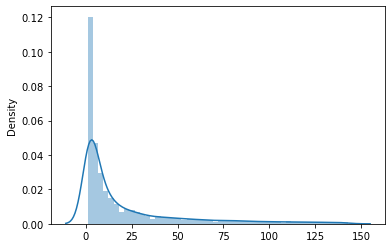

In [18]:
import seaborn as sns, numpy as np
after_re_outlier = user_act.values
ax = sns.distplot(after_re_outlier)

#### Choosing Company's Color Brand

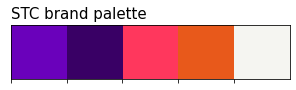

In [19]:
# Palette
sns.palplot(['#6A01BB', '#390065', '#FF375D','#e8591b','#f5f5f1' ])

plt.title("STC brand palette ",loc='left',fontsize=15,y=1)
plt.show()

# Data Visualization

## 1. Percentage of Program Type

### Processing

In [20]:
type_ratio = round(df.program_class.value_counts(normalize=True).to_frame().transpose(),2)

### Visualization

/var/folders/sn/7klq0gls5qz987z3jr52_jym0000gn/T/ipykernel_75545/2433531326.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_yticks([])


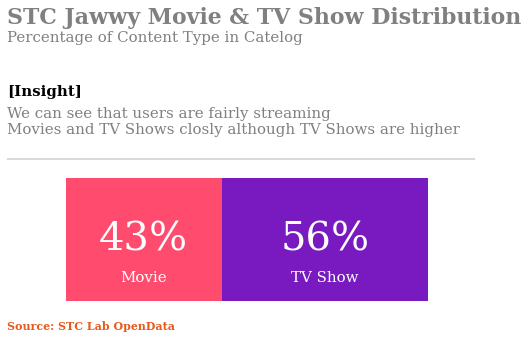

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(type_ratio.index, type_ratio['Movie'], 
        color='#FF375D', alpha=0.9)
ax.barh(type_ratio.index, type_ratio['TV Show'], left=type_ratio['Movie'], 
        color='#6A01BB', alpha=0.9)

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# movie percentage
for i in type_ratio.index:
    ax.annotate(f"{int(type_ratio['Movie'][i]*100)}%", 
                   xy=(type_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(type_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in type_ratio.index:
    ax.annotate(f"{int(type_ratio['TV Show'][i]*100)}%", 
                   xy=(type_ratio['Movie'][i]+type_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(type_ratio['Movie'][i]+type_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')


for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)


    
    # -------------------------------------- Title , Insight , Source --------------------------------------
n = 0.5
fig.text(0, 1.2+n, 'STC Jawwy Movie & TV Show Distribution', fontsize=22, fontweight='bold', fontfamily='serif', color='grey')   
fig.text(0, 1.1+n, """Percentage of Content Type in Catelog""",fontsize=15, fontweight='light', fontfamily='serif', color='grey')   

fig.text(0, 0.8+n, "[Insight]",fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(0, 0.5+n, """
We can see that users are fairly streaming 
Movies and TV Shows closly although TV Shows are higher 
"""
         ,fontsize=15, fontweight='light', fontfamily='serif', color='grey')   

import matplotlib.lines as lines
l1 = lines.Line2D([0, 1], [0.95, 0.95], transform=fig.transFigure, figure=fig,color='black',lw=0.3)
fig.lines.extend([l1])

fig.text(0, -0.5+n, "Source: STC Lab OpenData",fontsize=11, fontweight='bold', fontfamily='serif', color= '#e8591b')

# -----------------------------------------------------------------------------------------------

plt.show()


## Genre Percentage Collection in Jawwy

### Processing

In [22]:
genre_total = df.groupby(by=['program_class', 'program_genre'],as_index=False)['user_id'].count().sort_values('program_genre',ascending=False)
# remove any non duplicate genre 
dups = genre_total['program_genre'].value_counts()
genre_total = genre_total[genre_total['program_genre'].isin(dups[dups>1].index)]

genre_total = genre_total.pivot_table(index='program_genre',columns='program_class', values='user_id').reset_index()
genre_total.columns = [''.join(col) for col in genre_total.columns]
genre_total['Total'] = genre_total['Movie']+genre_total['TV Show']
genre_total = genre_total.sort_values('Movie', ascending=True)

genre_total['Movie'] = round(genre_total['Movie']/genre_total['Total']*100,2)
genre_total['TV Show'] = round((genre_total['TV Show'])/genre_total['Total']*100,2)

genre_total = genre_total.set_index('program_genre')
genre_total = genre_total.sort_values('Movie', ascending=False)

### Visualization 

/var/folders/sn/7klq0gls5qz987z3jr52_jym0000gn/T/ipykernel_75545/4012140414.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(genre_total.index,


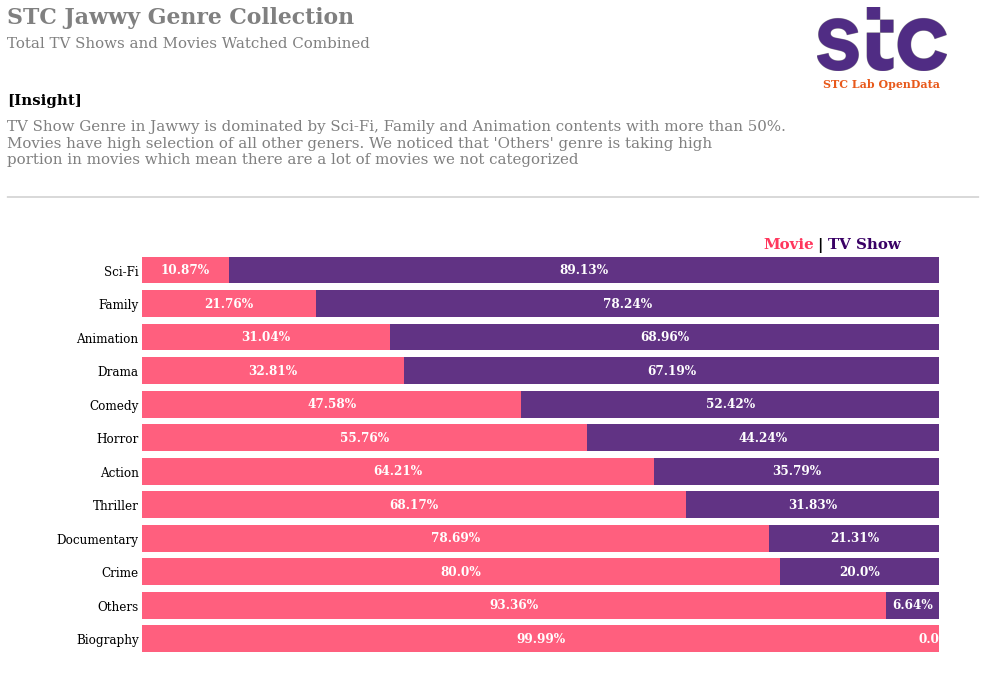

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15, 8),)
ax.barh(genre_total.index, genre_total['Movie'], 
        color='#ff375e', alpha=0.8, label='Movie')
ax.barh(genre_total.index, genre_total['TV Show'], left=genre_total['Movie'], 
        color='#390065', alpha=0.8, label='TV Show')

#ax.set_xticks([])
ax.set_yticklabels(genre_total.index,
                   fontfamily='serif', fontsize=11)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

# male percentage
for i in genre_total.index:
    ax.annotate(f"{genre_total['Movie'][i]:.4}%", 
                   xy=(genre_total['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='bold', fontfamily='serif',
                   color='white')

for i in genre_total.index:
    ax.annotate(f"{genre_total['TV Show'][i]:.4}%", 
                   xy=(genre_total['Movie'][i]+genre_total['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='bold', fontfamily='serif',
                   color='white')
    
    
# -------------------------------------- Title , Insight , Source --------------------------------------
n = 0.01
fig.text(0, 1.24+n, 'STC Jawwy Genre Collection', fontsize=22, fontweight='bold', fontfamily='serif', color='grey')   
fig.text(0, 1.2+n, """Total TV Shows and Movies Watched Combined""",fontsize=15, fontweight='light', fontfamily='serif', color='grey')   

fig.text(0, 1.1+n, "[Insight]",fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(0, 0.97+n, """
TV Show Genre in Jawwy is dominated by Sci-Fi, Family and Animation contents with more than 50%.
Movies have high selection of all other geners. We noticed that 'Others' genre is taking high 
portion in movies which mean there are a lot of movies we not categorized
"""
         ,fontsize=15, fontweight='light', fontfamily='serif', color='grey')   

import matplotlib.lines as lines
l1 = lines.Line2D([0, 0.9], [0.95, 0.95], transform=fig.transFigure, figure=fig,color='black',lw=0.3)
fig.lines.extend([l1])

fig.text(0.755, 1.14, "STC Lab OpenData",fontsize=11, fontweight='bold', fontfamily='serif', color= '#e8591b')

# -----------------------------------------------------------------------------------------------

fig.text(0.7,0.86,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#FF375D')
fig.text(0.75,0.86,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.76,0.86,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#390065')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)


im = image.imread('STC.png')
newax = fig.add_axes([0.75,1.16,0.12,0.12], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')


plt.show()

## High Definition Support

### Processing

In [24]:
#Number of HD in the Catlog
hd_size = df[['hd', 'vid_id']].drop_duplicates()
hd_size = hd_size.groupby(by="hd", as_index=False)['vid_id'].count()
hd_size['hd'] = np.where(hd_size['hd'] == 1, 'HD', 'SD')

### Visualization

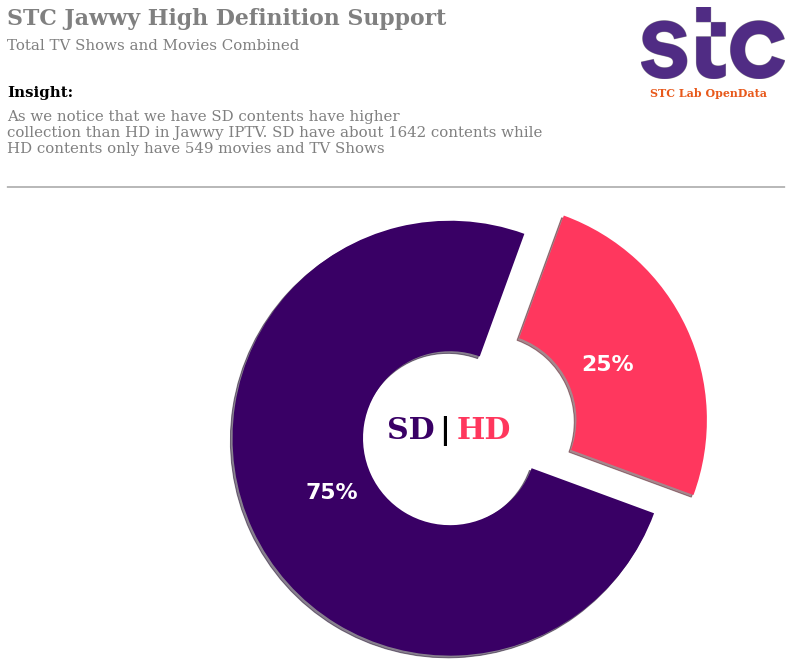

In [25]:
# create variables for data and labels and colors
pie_data = hd_size.loc[:,'vid_id']
pie_labels = hd_size.loc[:,'hd']
pie_color=['#390065','#ff375e'] 

# Make figure and axes
fig, ax = plt.subplots(1,1, figsize=(12, 5),)

# Adapt radius and text size for a smaller pie
patches, texts, autotexts = ax.pie(pie_data, 
                                     colors=pie_color,
                                     autopct='%.0f%%',
                                     textprops={'size': 30, 'color': 'black'},
                                     shadow=True, 
                                     radius=2,
                                     startangle=70, # change the angle to make small on the right side
                                     wedgeprops=dict(width=1.2), # create donut chart
                                     explode=(0,0.4) # make the small standout
                                    )


fig.text(0.44,0.5,"SD", fontweight="bold", fontfamily='serif', fontsize=30, color='#390065')
fig.text(0.5,0.5,"|", fontweight="bold", fontfamily='serif', fontsize=30, color='black')
fig.text(0.52,0.5,"HD", fontweight="bold", fontfamily='serif', fontsize=30, color='#FF375D')


# -------------------------------------- Title , Insight , Source --------------------------------------
n = 0.3
plt.setp(autotexts, size=22, weight="bold", color="white")
fig.text(0, 1.35+n, 'STC Jawwy High Definition Support', fontsize=22, fontweight='bold', fontfamily='serif', color='grey')   
fig.text(0, 1.28+n, """Total TV Shows and Movies Combined""",fontsize=15, fontweight='light', fontfamily='serif', color='grey')   



fig.text(0, 1.15+n, "Insight:",fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(0, 0.95+n, """
As we notice that we have SD contents have higher 
collection than HD in Jawwy IPTV. SD have about 1642 contents while 
HD contents only have 549 movies and TV Shows
""",fontsize=15, fontweight='light', fontfamily='serif', color='grey')   

import matplotlib.lines as lines
l1 = lines.Line2D([0, 0.9], [0.9+n, 0.9+n], transform=fig.transFigure, figure=fig,color='black',lw=0.3)
fig.lines.extend([l1])

l2 = lines.Line2D([0, 0.9], [0.9+n, 0.9+n], transform=fig.transFigure, figure=fig,color='black',lw=0.3)
fig.lines.extend([l2])

fig.text(0.744,1.45, "STC Lab OpenData",fontsize=11, fontweight='bold', fontfamily='serif', color= '#e8591b')

# -----------------------------------------------------------------------------------------------

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)


im = image.imread('STC.png')
newax = fig.add_axes([0.7,1.5,0.2,0.2], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')

plt.show()

### User Views Overtime by Type

### Processing

In [26]:
df['date_column']= df['date'].dt.to_period('M')
user_interactions = df.groupby(by=['date_column', 'program_class'], as_index=False).agg({"user_id": 'count'}).set_index('date_column')
user_interactions = pd.pivot_table(user_interactions, index='date_column', columns='program_class', values='user_id')

user_interactions.index= user_interactions.index.strftime('%y-%b')
date= user_interactions.index.astype(str)

### Visualization

/var/folders/sn/7klq0gls5qz987z3jr52_jym0000gn/T/ipykernel_75545/403479092.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['80K','100K','120K','140K', '160K', '180K', '190K', '200K'], fontsize=20, color='grey')
/var/folders/sn/7klq0gls5qz987z3jr52_jym0000gn/T/ipykernel_75545/403479092.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list((user_interactions.index)),fontsize=15, color='grey')


(-0.5, 1199.5, 599.5, -0.5)

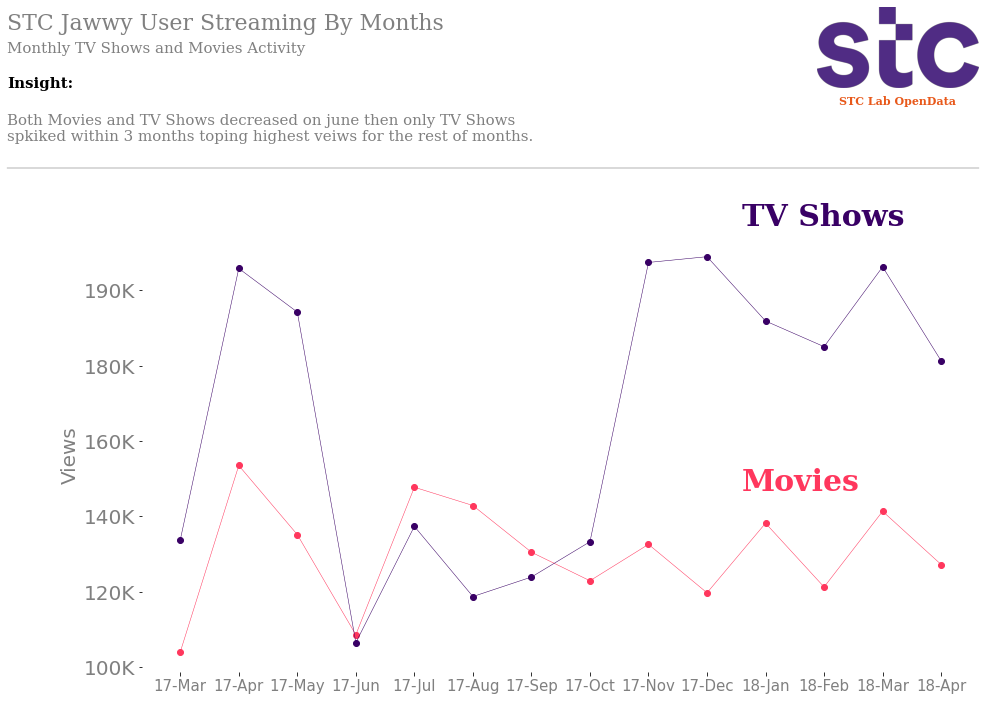

In [27]:
fig, ax = plt.subplots(figsize=(15, 8),)

ax.plot(date, user_interactions['Movie'], color='#FF375D', marker='o', lw=0.5)
ax.plot(date, user_interactions['TV Show'], color = '#390065', marker='o', lw=0.5)


# -------------------------------------- Title , Insight , Source --------------------------------------
n = 0.3
plt.setp(autotexts, size=22, weight="bold", color="white")
fig.text(0, 0.94+n, 'STC Jawwy User Streaming By Months', fontsize=22, fontweight='light', fontfamily='serif', color='grey')   
fig.text(0, 0.9+n, """Monthly TV Shows and Movies Activity""",fontsize=15, fontweight='light', fontfamily='serif', color='grey')   


fig.text(0, 0.84+n, "Insight:",fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(0, 0.72+n, """
Both Movies and TV Shows decreased on june then only TV Shows
spkiked within 3 months toping highest veiws for the rest of months.
""",fontsize=15, fontweight='light', fontfamily='serif', color='grey')   

import matplotlib.lines as lines
l1 = lines.Line2D([0, 0.9], [0.7+n, 0.7+n], transform=fig.transFigure, figure=fig,color='black',lw=0.3)
fig.lines.extend([l1])

fig.text(0.77, 1.11, "STC Lab OpenData",fontsize=11, fontweight='bold', fontfamily='serif', color='#e8591b')
# -----------------------------------------------------------------------------------------------

fig.text(0.68,0.9,"TV Shows", fontweight="bold", fontfamily='serif', fontsize=30, color='#390065')
fig.text(0.68,0.44,"Movies", fontweight="bold", fontfamily='serif', fontsize=30, color='#FF375D')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_yticklabels(['80K','100K','120K','140K', '160K', '180K', '190K', '200K'], fontsize=20, color='grey')
ax.set_ylabel('Views', fontsize=20, color='grey')
ax.set_xticklabels(list((user_interactions.index)),fontsize=15, color='grey')


im = image.imread('STC.png')
newax = fig.add_axes([0.75,1.13,0.15,0.15], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')

In [28]:
top_tv = df[df.program_class == 'TV Show']
top_tv = top_tv.groupby(by=['program_name'], as_index=False).agg({'user_id' :'count'}).sort_values(by=['user_id'], ascending=False).head(10)


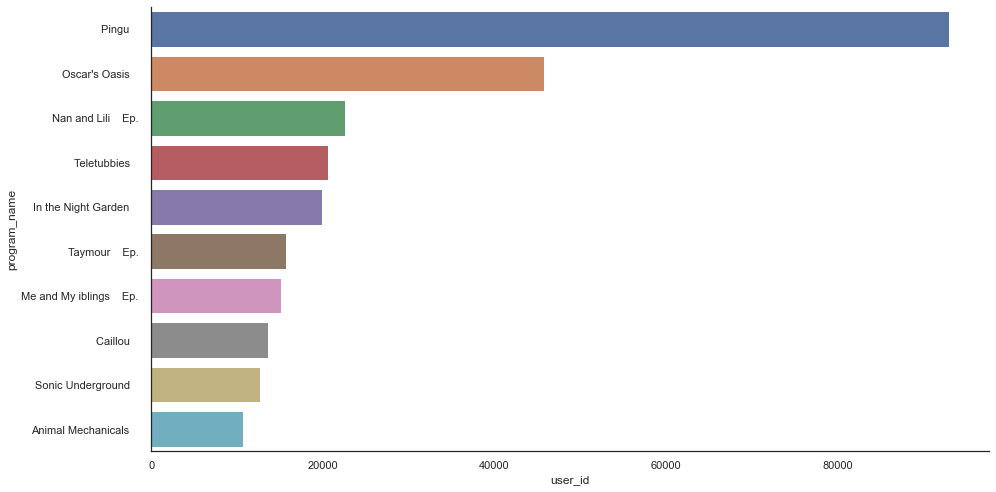

In [29]:

import seaborn as sns
y = top_tv.program_name
x = top_tv.user_id
# top movies
top_color = "#FF375D"
none_top_color = "#6A01BB"
# set the background to white
sns.set_theme(style="white")
# create chart and adding palette colors on top 3
chart = sns.catplot(
    data=top_tv, 
    y='program_name', 
    x='user_id', 
    kind="bar",
    height= 7,
    aspect=2,
    legend=False)


# Recommandation System

### <a class="anchor" id="Rank">Part I: Rank-Based Recommendations</a>

In Rank-Based Recommendations, we care about the number of content was interacted by users. By building a function to list a n top items can be insightful!

In [30]:
def get_top_items(n, df=df):
    '''
    INPUT:
    n - (int) the number of top top_items to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_items - (list) A list of the top 'n' items titles 
    
    '''
    # Your code here
    top_items = list(df.groupby('original_name').count()['user_id'].sort_values(ascending=False).index[:n,])
    
    return top_items # Return the top items titles from df (not df_content)

def get_top_items_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top_items to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_items - (list) A list of the top 'n' items titles 
    '''
    top_items = list(df.groupby('vid_id').count()['user_id'].sort_values(ascending=False).index[:n,])
 
    return top_items # Return the top item ids

In [32]:
top_10 = list(get_top_items(10))
top_10

['PAW Patrol  ',
 'Friends  ',
 'Pingu  ',
 'The Boss Baby',
 'Blaze And The Monster Machines  ',
 'The Walking Dead  ',
 'Marcus Level  (T)',
 'SpongeBob quarePants',
 'Dora the Explorer  ',
 "Oscar's Oasis  "]

## <a class="anchor" id="User-User">Part II: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an item, then place a 1 where the user-row meets for that item-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an item should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that item-column**. 

In [33]:
# I am subseting the dataset since it will take forever on my machine to compute similarity
df = df.head(100000)

In [34]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with item_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and item ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df = df[['user_id', 'original_name', 'vid_id']]
    user_item = df.groupby(['user_id', 'vid_id'])['vid_id'].count().unstack().notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [35]:
user_item

vid_id,0,1,2,3,4,5,6,7,8,9,...,1817,1818,1820,1821,1822,1823,1824,1825,1826,1827
user_id,,,,,,,,,,,,,,,,,,,,,
15,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34250,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculating User Similarities

In [36]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by items: 
                1's when a user has interacted with an items, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity=user_item.dot(np.transpose(user_item))
    # sort by similarity
    similarity_sort=similarity.sort_values(by=user_id, axis=1, ascending=False)
    
    # remove the own user's id
    similarity_sort = similarity_sort.drop(columns=user_id) 


    # create list of just the ids
    most_similar_users = similarity_sort.columns.tolist()
    
    return most_similar_users # return a list of the users in order from most to least similar

In [37]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(15)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(34254)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(57)[:3]))

The 10 most similar users to user 1 are: [4564, 25711, 20979, 17168, 17820, 13458, 25917, 4215, 26199, 22630]
The 5 most similar users to user 3933 are: [16945, 31644, 23732, 33217, 30546]
The 3 most similar users to user 46 are: [34277, 7971, 9988]


In [38]:
df['vid_id'] = df['vid_id'].astype(str)

/var/folders/sn/7klq0gls5qz987z3jr52_jym0000gn/T/ipykernel_75545/1090345545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vid_id'] = df['vid_id'].astype(str)


In [45]:
def get_item_names(user_id, df=df):
    '''
    INPUT:
    user_id - (list) a list of item ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    item_names - (list) a list of item names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    item_names = list(set(df[df['vid_id'].isin(user_id)]['original_name'].values))
    
    return item_names # Return the item names associated with list of items ids

In [51]:
def get_user_items(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by items: 
                1's when a user has interacted with an items, 0 otherwise
    
    OUTPUT:
    items_ids - (list) a list of the items ids seen by the user
    items_names - (list) a list of items names associated with the list of items ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the items_ids and items titles that have been seen by a user
    '''
    user_idx = user_item.loc[user_id, :]
    items_ids = user_idx[user_idx == 1].index.values.astype('str').tolist()
    items_names = get_item_names(items_ids)
    
    return items_ids, items_names

In [52]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    
    # retrieve similar user lists
    
    # loop through the users based on the closeness
    ## remove watched movie by the user 1:
    most_similar_users = find_similar_users(user_id)
    
    # Give user_item_ids which user read
    user_item_ids = set(get_user_items(user_id)[0])
    
    # -- Storing recommendations for user
    recs = []
    for user in most_similar_users:
        closer_user_item_ids = set(get_user_items(user)[0])
        recs += list(set(closer_user_item_ids) - set(user_item_ids))
        if len(recs) > m:
            break
 
    return recs[:m] # return your recommendations for this user_id    

In [53]:
# Check Results
get_item_names(user_user_recs(34277, 10)) # Return 10 recommendations for user 1

['Baywatch',
 "Surf's Up : WaveMania",
 'Spider-Man: Homecoming',
 'Rings',
 'Guardians Of The Tomb',
 'The hape of Water',
 'The Greatest howman',
 'Moana',
 'Inside']

In [56]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by item: 
            1's when a user has interacted with an item, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # compute similarity of user_id to grab all users
    similarity = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)
    # add it to new dataframe and delete user_id from the the dataframe
    similarity = pd.DataFrame(similarity[1:]).reset_index()
    # rename columns
    similarity.columns = ['user_id','similarity']

    # set another metric of number of interaction of each user in the df
    num_interations = df.groupby('user_id').count()['vid_id']
    num_interations = pd.DataFrame(num_interations[1:]).reset_index()
    num_interations.columns = ['user_id', 'num_interations']
    # join num_interations to similarity dataframe 
    neighbors_df = similarity.merge(num_interations, how='outer', on='user_id')
    neighbors_df.columns = ['user_id', 'similarity', 'num_interations']
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interations'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by item id
    rec_names - (list) a list of recommendations for the user by item title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total item interactions 
    before choosing those with fewer item interactions.

    * Choose articles with the items with the most total interactions 
    before choosing those with fewer total interactions. 
    
    
    '''
    # Your code here
    
    # target user article ids
    the_user_items = list(set(get_user_items(user_id)[0]))


    recs = []
    # get all neighbors users df
    neighbors_df = get_top_sorted_users(user_id)
    # loop through each user and get their article ids and store it in recs (only store unique to our target)
    for user in neighbors_df['user_id']:
        user_items_ids = get_user_items(user)[0]# get items ids for check
        for art in user_items_ids:
            if art not in the_user_items:
                recs.append(art)
                if len(recs) >= m:
                    break
        if len(recs) >= m:
            break            

    # if we have less than m, we will fill in articles from top articles
    if len(recs) < m:
        for id in get_top_item_ids(m):
            if id not in the_user_items:
                recs.append(id)
                if len(recs) >= m:
                    break
    rec_names = get_item_names(recs)
    
    return recs, rec_names

In [57]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(12602, 10)
print("The top 10 recommendations for user 12602 are the following item ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 12602 are the following item names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['2', '35', '54', '96', '166', '175', '178', '246', '276', '336']

The top 10 recommendations for user 20 are the following article names:
['Avengers Confidential: Black Widow', 'About Last Night', 'Bad Boys ', 'Allied', 'Badges of Fury', 'Broken Vows', '100 treets', 'Blitz', 'A Fighting Man', 'Collateral Beauty']


# <a class="anchor" id="Matrix-Fact">Part III: Matrix Factorization</a>

In this part of the notebook, I will use matrix factorization to make item recommendations to the users on the STC IPTV Data.

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
df_train = df.sample(frac=0.7, random_state=25)
df_test = df.drop(df_train.index)

print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")

No. of training examples: 70000
No. of testing examples: 30000


In [63]:

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [64]:
user_item_train.head()

vid_id,0,1,10,100,1000,1001,1002,1003,1005,1006,...,988,99,991,992,993,995,996,997,998,999
user_id,,,,,,,,,,,,,,,,,,,,,
15,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [66]:
# decomposition to predict on test data

row_index = user_item_train.index.isin(test_idx)
col_index = user_item_train.columns.isin(test_arts)
u_test = u_train[row_index, :]
vt_test = vt_train[:, col_index]
test_users = set(user_item_train.index) & set(user_item_test.index)
test_articles = set(user_item_train.columns) & set(user_item_test.columns)
user_item_test_could_pred = user_item_test.loc[test_users, test_articles]

In [67]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_could_pred, user_item_test_est)
    
    # total errors and keep track of them
    sum_errs_train.append(np.sum(np.sum(np.abs(diffs_train))))
    sum_errs_test.append(np.sum(np.sum(np.abs(diffs_test))))

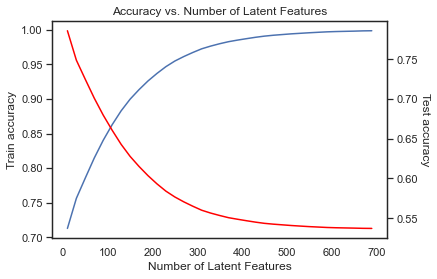

In [68]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], label="Train accuracy")
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color='red', label="Test accuracy")

ax1.set_title('Accuracy vs. Number of Latent Features')

ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Train accuracy')
ax2.set_ylabel('Test accuracy', rotation=270, labelpad=12)

plt.show()

### Analysis
We notice that the higher the latent feature for test we are approaching to lower accuracy and with higher dataset size like train dataset, 
we get higher accuracy when increasing latent features

### Discussion and future improvement for STC Jawwy
* We could say that accuracy is a great way to measure the given the number of latent features but we could also look for other similarities methods such as (Pearson’s correlation coefficient, Spearman’s correlation coefficient, Kendall’s Tau, Euclidean Distance , Manhattan Distance)
* It is not sufficient that we have our data split into random as we can pick more users from train that are exist in test, and we can develop a better framework to check for that. also the number of users in test fairly large to work in smaller environments however, the obvious is that all recommendation systems will scale and should have more users.
* Can we use an online evaluation technique like A/B testing here? Yes, to better improve our dataset, we need more data points for segmentation in order for A/B testing to be effective so that we understand how we can recommend using geo, demo, and personalization recommendations based on users characteristics, and it is always better to use methods such as similarities and num_interaction along other variables to better recommend users
* From the given data, I only used a subset of 100k data to reduce the computation but we can use the 3M for better server.
* The data needs more variables to optimize recommendation systems with more accuracy to users. a few of examples would be adding (rating from users, adding program year, item id, description to enhance content-based recommender